In [ ]:
!pip install imblearn
!pip install git+https://github.com/helias/shap.git@support-adaboost

!pip install xgboost
!pip install spicy
!pip install lightgbm

  Cloning https://github.com/helias/shap.git (to revision support-adaboost) to /tmp/pip-req-build-_hz3gay6
  Running command git clone --filter=blob:none --quiet https://github.com/helias/shap.git /tmp/pip-req-build-_hz3gay6
  Running command git checkout -b support-adaboost --track origin/support-adaboost
  Switched to a new branch 'support-adaboost'
  Branch 'support-adaboost' set up to track remote branch 'support-adaboost' from 'origin'.
  Resolved https://github.com/helias/shap.git to commit 2cc661461a7f3f51a2a6e7e022289c081e9243a3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shap: filename=shap-0.1.dev2810-cp311-cp311-linux_x86_64.whl size=3148971 sha256=20b4d80b73568b345b9e4b5b6e343af718ef4b1c757ba1aa4f75852cf86394fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-p5kfx8kl/wheels/e2/83/43/cfafb19b336a06639c5ba7c0e694ceeeecbfb3e3dd13058cc0
Successfully built shap
  Atte

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import shap
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import spicy
import warnings
warnings.filterwarnings("ignore")
def generate_label(row):
    if row['VAP']:
        return 1
    elif row['CLABSI']:
        return 0
    elif row['CAUTI']:
        return 0
    else:
        return 0



def load_data(threshold : float = 0.6):
  # 載入資料
  url = 'all_data_4_17.csv' # 替換成你的資料集檔名
  data = pd.read_csv(url)


  # Drop columns with too many missing values
  data = data.drop(['subject_id', 'hadm_id', 'stay_id', 'icd_code', 'icd_version', 'intime', 'icu_length_of_survival',
              'los', 'hospital_length_of_survival', 'in_hospital_mortality', 'infection_sum', 'glucose_min_1', 'glucose_max_1'
              , 'icu_mortality'], axis=1)

  threshold = len(data) * threshold #tune your own threshold

  data = data.dropna(axis=1, thresh=threshold)
  # 處理缺失值：將缺失值視為 0 -> mean
  for i in data:
    data[i].fillna(data[i].mean(), inplace=True)
  data['label'] = data.apply(generate_label, axis=1)

  #for i in data:
  #  print(i, spicy.stats.spearmanr(data[i].tolist(), data['label'].tolist()))
  # shuffle the data
  data = data.sample(frac=1, random_state=42)
  data = data.reset_index(drop=True)
  return data

# 創建新的標籤欄位

def split_data(data, portion):



  # 分割特徵與標籤
  x = data.drop(['label', 'VAP', 'CLABSI', 'CAUTI', 'apsiii'], axis=1)  # 'label' 為新生成的目標欄位
  y = data['label']

  # Binarize y for OvR ROC curves
  classes = sorted(y.unique())
  y = label_binarize(y, classes=classes)

  # 分割訓練集與測試集
  x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify = y, test_size = portion, random_state=42
  )

  return x_train, x_test, y_train, y_test, classes

def smote_data(X_train, y_train, knn_count = 3):
  # 使用適用於多類標籤的 SMOTE
  # 使用適用於多類標籤的 SMOTE，並設定 k_neighbors 參數
  # enn = EditedNearestNeighbours()
  # X_train, y_train = enn.fit_resample(X_train, y_train)
  smote = SMOTE(random_state=42, k_neighbors = knn_count)
  x_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
  return x_train_resampled, y_train_resampled

def adasyn_data(X, y, random_state=42):
    ada = ADASYN(random_state=random_state)
    X_res, y_res = ada.fit_resample(X, y)
    return X_res, y_res


def train_model(x_train_resampled, y_train_resampled, model):
  model.fit(x_train_resampled, y_train_resampled)
  return model


def monitor_results(model, x_train_resampled, x_test, y_train_resampled, y_test):

  #訓練結果
  y_pred = model.predict(x_train_resampled)
  accuracy = accuracy_score(y_train_resampled, y_pred)
  precision = precision_score(y_train_resampled, y_pred, average='weighted')  # 使用加權平均處理多類標籤
  recall = recall_score(y_train_resampled, y_pred, average='weighted')
  f1 = f1_score(y_train_resampled, y_pred, average='weighted')
  print("Training Results:")
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  # 使用 classification_report 顯示詳細報告
  print("\nClassification Report:")
  print(classification_report(y_train_resampled, y_pred))


  #測試結果
  y_pred = model.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')  # 使用加權平均處理多類標籤
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')
  print("Testing Results:")
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  # 使用 classification_report 顯示詳細報告
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  return accuracy, precision, recall, f1


def plot_roc_curve(models, x_tests, y_test, classes, prefix = ''):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

    def bootstrap_auc_ci(y_true, y_score, n_bootstraps=1000, alpha=0.95, seed=42):
        np.random.seed(seed)
        bootstrapped_scores = []
        for _ in range(n_bootstraps):
            indices = np.random.randint(0, len(y_true), len(y_true))
            if len(np.unique(y_true[indices])) < 2:
                continue
            score = auc(*roc_curve(y_true[indices], y_score[indices])[:2])
            bootstrapped_scores.append(score)
        sorted_scores = np.sort(bootstrapped_scores)
        lower = np.percentile(sorted_scores, (1 - alpha) / 2 * 100)
        upper = np.percentile(sorted_scores, (1 + alpha) / 2 * 100)
        return lower, upper

    # Allow models to be passed as a list or a single model
    if not isinstance(models, list):
        models = [models]
    if not isinstance(x_tests, list):
        x_tests = [x_tests]

    class_map = {
        0: 'NONE',
        1: 'VAP',
        2: 'CLABSI',
        3: 'CAUTI'
    }

    for i, class_label in enumerate(classes):
        if i == 0:
            continue  # Skip NONE

        # Get true binary labels
        y_true = y_test[:, i] if len(classes) > 2 else y_test

        plt.figure(figsize=(10, 8))

        for model_idx, model in enumerate(models):
            model_name = model.__class__.__name__
            y_proba = model.predict_proba(x_tests[0])

            if len(classes) > 2:
                y_pred_proba = y_proba[i][:, 1]
            else:
                y_pred_proba = y_proba[:, 1]

            # ROC
            fpr_model, tpr_model, _ = roc_curve(y_true, y_pred_proba)
            roc_auc_model = auc(fpr_model, tpr_model)
            ci_lower, ci_upper = bootstrap_auc_ci(y_true, y_pred_proba)

            # Plot ROC
            plt.plot(fpr_model, tpr_model,
                     label=f'{model_name} (AUC = {roc_auc_model:.2f}, 95% CI: {ci_lower:.2f}-{ci_upper:.2f})')

        # Plot APSIII baseline
        fpr_apsiii, tpr_apsiii, _ = roc_curve(data[class_map[i]], data['apsiii'])
        roc_auc_apsiii = auc(fpr_apsiii, tpr_apsiii)
        plt.plot(fpr_apsiii, tpr_apsiii, '--', label=f'APSIII (AUC = {roc_auc_apsiii:.2f})')

        plt.title(f'{prefix} ROC Curve: {class_map[class_label]}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right', fontsize='small')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


## 使用 SHAP 解釋模型
#explainer = shap.TreeExplainer(rf, X_train)
#shap_values = explainer.shap_values(X_test)
#class_name = ['NONE', 'VAP', 'CLABSI', 'CAUTI']
## 可視化 SHAP 值（針對每個類別進行解釋）
#for i, index in enumerate(rf.classes_):
#    print(f"SHAP 值可視化 - 類別 {class_name[index]}")
#    shap.summary_plot(shap_values[:, :, i], X_test, class_names=rf.classes_, title=f"SHAP Summary for Class {class_name[index]}") # This fixes the error

# 缺失值分析

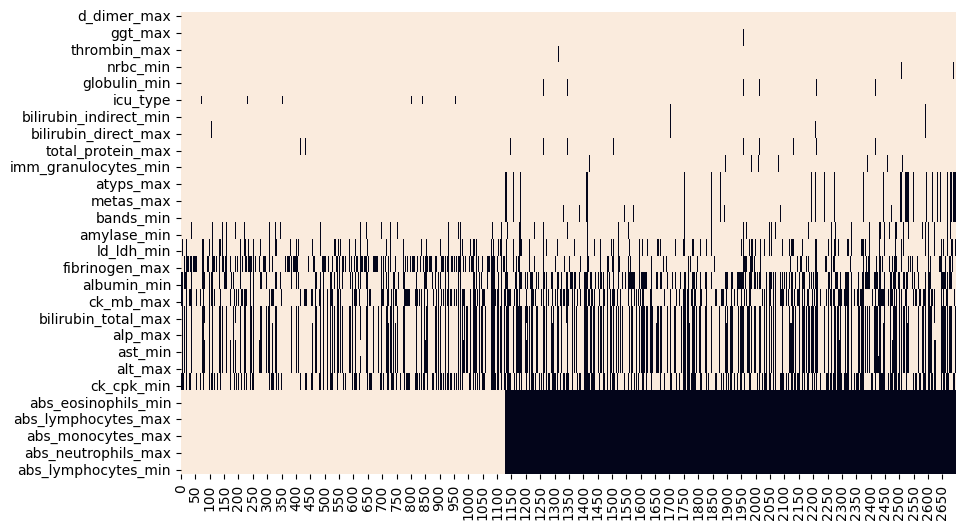

,count,percent
d_dimer_max,2696,99.962922
d_dimer_min,2696,99.962922
ggt_max,2694,99.888765
ggt_min,2694,99.888765
thrombin_max,2692,99.814609
thrombin_min,2692,99.814609
nrbc_min,2684,99.517983
nrbc_max,2684,99.517983
globulin_min,2677,99.258435
globulin_max,2677,99.258435


In [5]:
url = '/content/drive/MyDrive/all_data_4_17.csv' # 替換成你的資料集檔名
data = pd.read_csv(url)


# Drop columns with too many missing values
data = data.drop(['subject_id', 'hadm_id', 'stay_id', 'icd_code', 'icd_version', 'intime', 'icu_length_of_survival',
            'los', 'hospital_length_of_survival', 'in_hospital_mortality', 'infection_sum', 'glucose_min_1', 'glucose_max_1'
            , 'icu_mortality'], axis=1)
# rank columns from most missing to least missing
missing_rank = data.isnull().sum().sort_values(ascending=False)

# plot the most missing 55 missing columns into a heatmap
top_55_missing = missing_rank.head(55)
plt.figure(figsize=(10, 6))
sns.heatmap(data[top_55_missing.index].isnull().transpose(), cbar=False)
plt.show()

missing_df = pd.DataFrame(missing_rank)
missing_df.columns = ['count']
missing_df['percent'] = missing_df['count'] / len(data) * 100
missing_df.head(56)

In [6]:
rf_config = {
    'n_estimators': 5000,
    'max_depth': 5,
    'max_features': 'sqrt',
    'bootstrap': True,
    'min_samples_leaf': 1,
    'min_samples_split': 3,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': 16,
    'verbose': 1
}
# xgb_config = {
#     'n_estimators' : 2000,
#     'max_depth' : 5,
#     'learning_rate' : 1e-3,
#     'objective' : 'binary:logistic',
#     'alpha' : 10,
#     'gamma' : 1,
# }
xgb_config = {
    'n_estimators' : 1000,
    'max_depth' : 5,
    'learning_rate' : 0.01,
    'objective' : 'binary:logistic',
    'alpha' : 10,
    'gamma' : 1,
    'random_state': 42,
}
lgbm_config = {
    'n_estimators': 300,
    'learning_rate': 0.01,
    'max_depth': 6,
    'random_state': 42,
    # 'is_unbalance': True,
    'class_weight': 'balanced',
    'verbose': -1
}
knn_config = {
    'n_neighbors': 4,
    'weights': 'uniform',
    'algorithm': 'auto',
    'leaf_size': 30,
    'p': 2,
    'metric': 'minkowski',
    'metric_params': None
}
ada_config = {
    'n_estimators': 500,
    'learning_rate': 1,
}
dt_config = {
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import itertools

def manual_grid_search_auc(model_class, param_grid, X, y, n_splits=5, early_stopping=False, method = 'adasyn'):

    # Initialize variables
    best_score = -np.inf
    best_params = None
    results = []

    # Create param combinations
    keys = list(param_grid.keys())
    combinations = list(itertools.product(*[param_grid[k] for k in keys]))

    # Cross-validation
    for combo in combinations:
        params = dict(zip(keys, combo))
        scores = []

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for train_idx, val_idx in kf.split(X, y):
            # Split data
            x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            if (method == 'adasyn'):
              x_train, y_train = adasyn_data(x_train, y_train)
            elif (method == 'smote'):
              x_train, y_train = smote_data(x_train, y_train)

            # Instantiate model
            model = model_class(**params)

            # Fit with early stopping if supported
            if early_stopping and hasattr(model, 'fit') and 'early_stopping_rounds' in model.get_params():
                model.set_params(early_stopping_rounds=10, eval_metric='auc')
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=False)
            else:
                model.fit(x_train, y_train)

            # Predict probabilities
            if isinstance(model, SVC):
                y_pred = model.decision_function(x_val)
                _auc = roc_auc_score(y_val, y_pred)
            else:
                y_proba = model.predict_proba(x_val)

                # Handle binary or multiclass
                try:
                    if y_proba.shape[1] == 2:
                        y_pred = y_proba[:, 1]
                        _auc = roc_auc_score(y_val, y_pred)
                    else:
                        _auc = roc_auc_score(y_val, y_proba, multi_class='ovr')
                except Exception as e:
                    print(f"[WARN] Failed AUC: {e}")
                    _auc = np.nan

            scores.append(_auc)

        avg_score = np.nanmean(scores)
        print(f"Params: {params} --> Avg AUC: {avg_score:.4f}")

        results.append((params, avg_score))
        if avg_score > best_score:
            best_score = avg_score
            best_params = params

    print("\nBest Parameters:")
    print(best_params)
    print(f"Best AUC: {best_score:.4f}")
    return best_params, best_score, results

def run_gridsearch_all_models(x_train, y_train, method = 'adasyn'):
    # Define models and their parameter grids
    model_configs = {
        'RandomForest': {
            'model': RandomForestClassifier,
            'params': {
                'n_estimators': [200, 500, 1000],
                'max_depth': [10, 15],
                'min_samples_split': [2, 5]
            }
        },
        'XGBoost': {
            'model': XGBClassifier,
            'params': {
                'n_estimators': [1500, 4000],
                'max_depth': [5, 7],
                'learning_rate': [0.01, 1e-3],
                'eval_metric': ['logloss'],
                'objective' : ['binary:logistic'],
                'alpha' : [1],
                'gamma' : [0.1],
            }
        },
        'KNN': {
            'model': KNeighborsClassifier,
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto'],
                'leaf_size': [30],
                'p': [2],
                'metric': ['minkowski'],
                'metric_params': [None]
            }
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier,
            'params': {
                'max_depth': [5, 15, 20, None],
                'min_samples_split': [2, 5]
            }
        },
        'AdaBoost': {
            'model': AdaBoostClassifier,
            'params': {
                'n_estimators': [500, 1000, 2000],
                'learning_rate': [0.5, 1.0]
            }
        },
        'LightGBM': {
            'model': LGBMClassifier,
            'params': {
                'n_estimators': [500, 1000, 2000],
                'max_depth': [6, 8],
                'learning_rate': [0.1, 0.5],
                'class_weight': ['balanced'],
                'random_state': [42],
                'verbose': [-1]
            }
        },

    }

    best_models = {}
    best_scores = {}
    records = {}

    for name, config in model_configs.items():
        print(f"\nRunning GridSearchCV for {name}...")
        best_params, best_score, record = manual_grid_search_auc(config['model'], config['params'], x_train, y_train, n_splits=5, early_stopping=False, method = method)
        if (best_params == None): continue
        best_models[name] = config['model'](**best_params)
        best_scores[name] = best_score
        records[name] = record

    return best_models, best_scores, records

## AdaSyn model selection

In [8]:
data = load_data(threshold = 0.1)
x_train, x_test, y_train, y_test, classes = split_data(data, 0.2)
# 不處理SVM
best_models, best_scores, records = run_gridsearch_all_models(x_train, y_train, 'adasyn')


Running GridSearchCV for RandomForest...
Params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2} --> Avg AUC: 0.6978
Params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5} --> Avg AUC: 0.6947
Params: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 2} --> Avg AUC: 0.6952
Params: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5} --> Avg AUC: 0.6738
Params: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2} --> Avg AUC: 0.6936
Params: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5} --> Avg AUC: 0.6900
Params: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 2} --> Avg AUC: 0.6878
Params: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 5} --> Avg AUC: 0.6839
Params: {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 2} --> Avg AUC: 0.6952
Params: {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 5} --> Avg AUC: 0.6958
Params: {'n_estimators': 1000, 'max_depth': 15

In [ ]:
adasyn_models = [i for i in best_models.values()]

[train_model(x_train, y_train, model) for model in adasyn_models]
[monitor_results(model, x_train, x_test, y_train, y_test) for model in adasyn_models]
plot_roc_curve(adasyn_models, x_test, y_test, classes)

## SMOTE model selection

這部分可以不用執行，只是為了比較SMOTE跟ADASYN的差別

In [ ]:
data = load_data(threshold = 0.1)
x_train, x_test, y_train, y_test, classes = split_data(data, 0.2)
# x_train, y_train = smote_data(x_train, y_train)
# x_train, y_train = adasyn_data(x_train, y_train)
best_models, best_scores, records = run_gridsearch_all_models(x_train, y_train, 'smote')

In [ ]:
smote_models = [i for i in best_models.values()]

[train_model(x_train, y_train, model) for model in smote_models]
[monitor_results(model, x_train, x_test, y_train, y_test) for model in smote_models]
# plot_roc_curve(smote_models, x_test, y_test, classes)
plot_roc_curve(smote_models, [x_test]*len(smote_models), y_test, classes)

## Pick the top X features form shap

In [10]:
"""
AdaSyn
rf {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5}
XGBoost {'n_estimators': 1500, 'max_depth': 5, 'learning_rate': 0.01, 'eval_metric': 'logloss', 'objective': 'binary:logistic', 'alpha': 1, 'gamma': 0.1}
knn {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 30, 'p': 2, 'metric': 'minkowski', 'metric_params': None}
DecisionTree {'max_depth': 3, 'min_samples_split': 2}
AdaBoost {'n_estimators': 1000, 'learning_rate': 1.0}
LightGBM {'n_estimators': 2000, 'max_depth': 6, 'learning_rate': 0.1, 'class_weight': 'balanced', 'random_state': 42, 'verbose': -1}

"""

model_config = {
    'RandomForest': {
        'model': RandomForestClassifier,
        'params': {
            'n_estimators': 200,
            'max_depth': 10,
            'min_samples_split': 2
        }
    },
    'XGBoost': {
        'model': XGBClassifier,
        'params': {'n_estimators': 4000,
              'max_depth': 5,
              'learning_rate': 0.01,
              'eval_metric': 'logloss',
              'objective': 'binary:logistic',
              'alpha': 1,
              'gamma': 0.1
        }
    },
    'KNN': {
        'model': KNeighborsClassifier,
        'params': {
            'n_neighbors': 7,
            'weights': 'distance',
            'algorithm': 'auto',
            'leaf_size': 30,
            'p': 2,
            'metric': 'minkowski',
            'metric_params': None
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier,
        'params': {
            'max_depth': 5,
            'min_samples_split': 5
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier,
        'params': {
            'n_estimators': 1000,
            'learning_rate': 1.0
        }
    },
    'LightGBM': {
        'model': LGBMClassifier,
        'params': {
            'n_estimators': 2000,
            'max_depth': 8,
            'learning_rate': 0.1,
            'class_weight': 'balanced',
            'random_state': 42,
            'verbose': -1
        }
    },

}

In [11]:
best_models = {}
for name, config in model_config.items():
    best_models[name] = config['model'](**config['params'])
data = load_data(threshold = 0.1)
x_train, x_test, y_train, y_test, classes = split_data(data, 0.2)
x_train, y_train = adasyn_data(x_train, y_train)
best_models

{'RandomForest': RandomForestClassifier(max_depth=10, n_estimators=200),
 'XGBoost': XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=0.1, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.01, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=4000,
               n_jobs=None, num_parallel_tree=None, ...),
 'KNN': KNeighborsClassifier(n_neighbors=7),
 'DecisionTree': DecisionTreeClassifier(max_depth=3),
 'AdaBoost': AdaBoostClassifier(n_estimators=1000),
 'Li

In [12]:
from sklearn.base import clone
bms_clone = {
    names : clone(model) for names, model in best_models.items()
}
[train_model(x_train, y_train, model) for model in bms_clone.values()]

[RandomForestClassifier(max_depth=10, n_estimators=200),
 XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=0.1, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.01, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=4000,
               n_jobs=None, num_parallel_tree=None, ...),
 KNeighborsClassifier(n_neighbors=7),
 DecisionTreeClassifier(max_depth=3),
 AdaBoostClassifier(n_estimators=1000),
 LGBMClassifier(class_weight='balanced', max_depth=6, n_estimators

In [ ]:
# important_features_dict = {}
# for idx, val in enumerate(model.feature_importances_):
#     important_features_dict[idx] = val

# important_features_list = sorted(important_features_dict,
#                                  key=important_features_dict.get,
#                                  reverse=True)

# print(f'5 most important features: {[x_train.columns[important_features_list[i]]  for i in range(5)]}')
# print(f'Importances = {model.feature_importances_[:5]}')

In [ ]:
data['label']

In [32]:
# shap for random tree and decision tree
def shap_for_rt(model, x_test):
  # Create the SHAP explainer for the Random Forest model
  explainer = shap.TreeExplainer(model)

  # Calculate SHAP values for the test set
  shap_values = explainer.shap_values(x_test)


  # Generate a SHAP summary plot
  shap.summary_plot(shap_values[:, :, 1], x_test, plot_type="bar")
  shap.summary_plot(shap_values[:, :, 1], x_test)

  return shap_values

# shap for xgb
def shap_for_xgb(model, x_test):
  # Create the SHAP explainer for the Random Forest model
  explainer = shap.TreeExplainer(model)

  # Calculate SHAP values for the test set
  shap_values = explainer.shap_values(x_test)

  # Generate a SHAP summary plot
  shap.summary_plot(shap_values, x_test, plot_type="bar")
  shap.summary_plot(shap_values, x_test)

  return shap_values

def shap_for_ada(model, x_test):
  # Create the SHAP explainer for the Random Forest model
  explainer = shap.TreeExplainer(model)

  # Calculate SHAP values for the test set
  shap_values = explainer.shap_values(x_test)
  # Generate a SHAP summary plot
  shap.summary_plot(shap_values[:, :, 1], x_test, plot_type="bar")
  shap.summary_plot(shap_values[:, :, 1], x_test)

  return shap_values

# shap for non tree
def f(x):
  return model.predict_proba(x)[:, 1]
def shap_for_non_tree(model, x_train, x_test):

  # Use SHAP to explain the model
  med = pd.DataFrame(x_train.median().values.reshape((1, x_train.shape[1])), columns = x_train.columns)

  explainer = shap.Explainer(f, med)
  shap_values = explainer(x_test)

  # Visualize SHAP values
  #長條圖顯示該feature的所有shap value的平均
  shap.summary_plot(shap_values, x_test, plot_type="bar")
  #這張圖顯示所有feature的值和shap value
  shap.summary_plot(shap_values, x_test)

  return shap_values

# shap for svm
# 執行時間較長
def shap_for_svm(model, x_test):
  # Use SHAP to explain the model
  explainer = shap.KernelExplainer(model.predict_proba, x_train)
  shap_values = explainer.shap_values(x_test)
  # Visualize SHAP values
  #長條圖顯示該feature的所有shap value的平均
  shap.summary_plot(shap_values[:, :, 1], x_test, plot_type="bar")
  #這張圖顯示所有feature的值和shap value
  shap.summary_plot(shap_values[:, :, 1], x_test)

  return shap_values


RandomForestClassifier(max_depth=10, n_estimators=200)
######   Printing Shap Values for RandomForest   ######


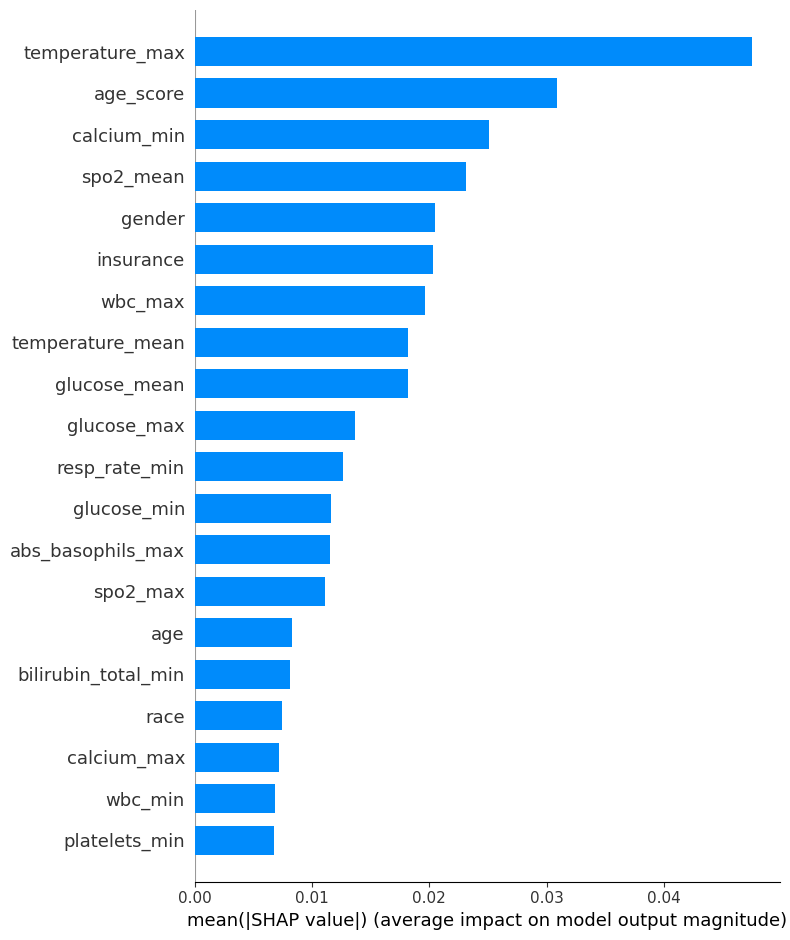

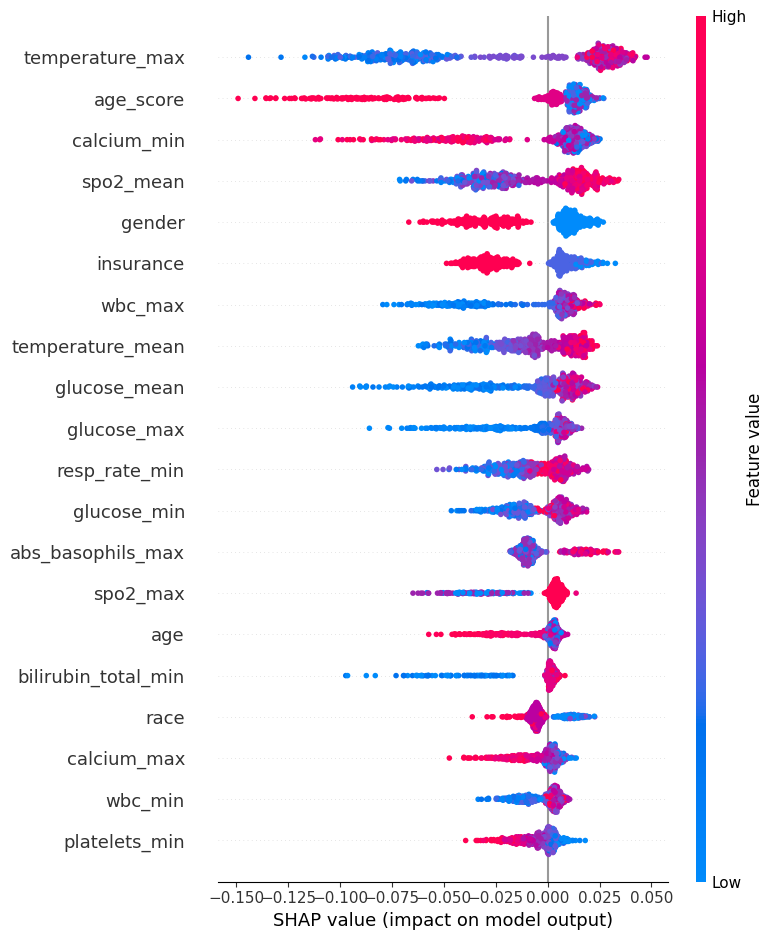

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4000,
              n_jobs=None, num_parallel_tree=None, ...)
######   Printing Shap Values for XGBoost   ######


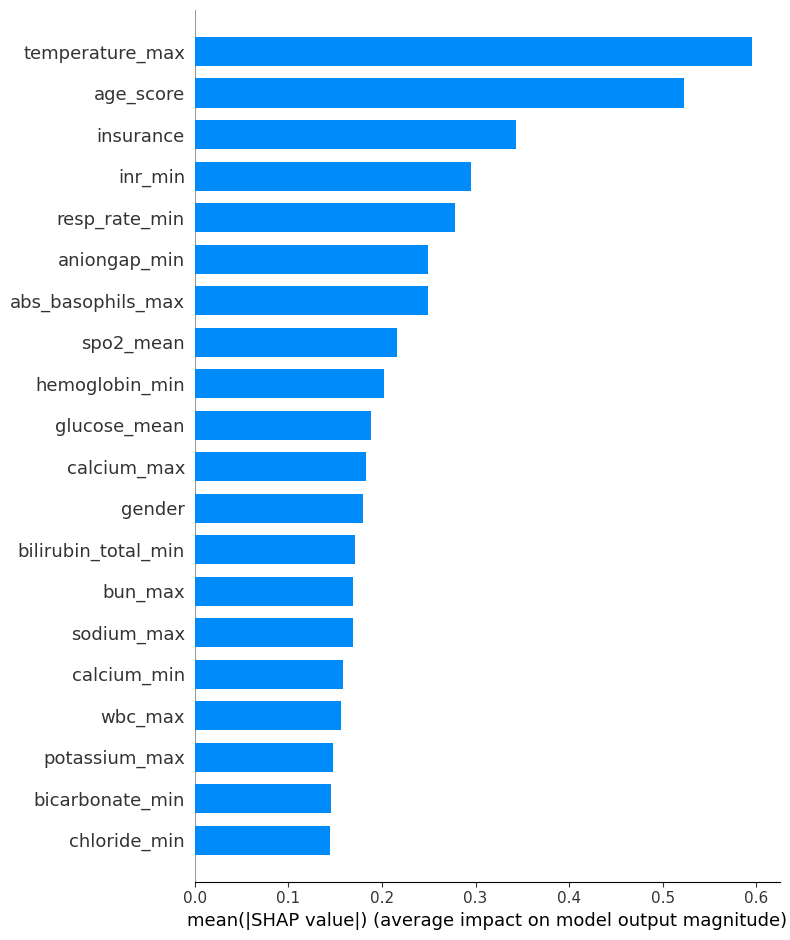

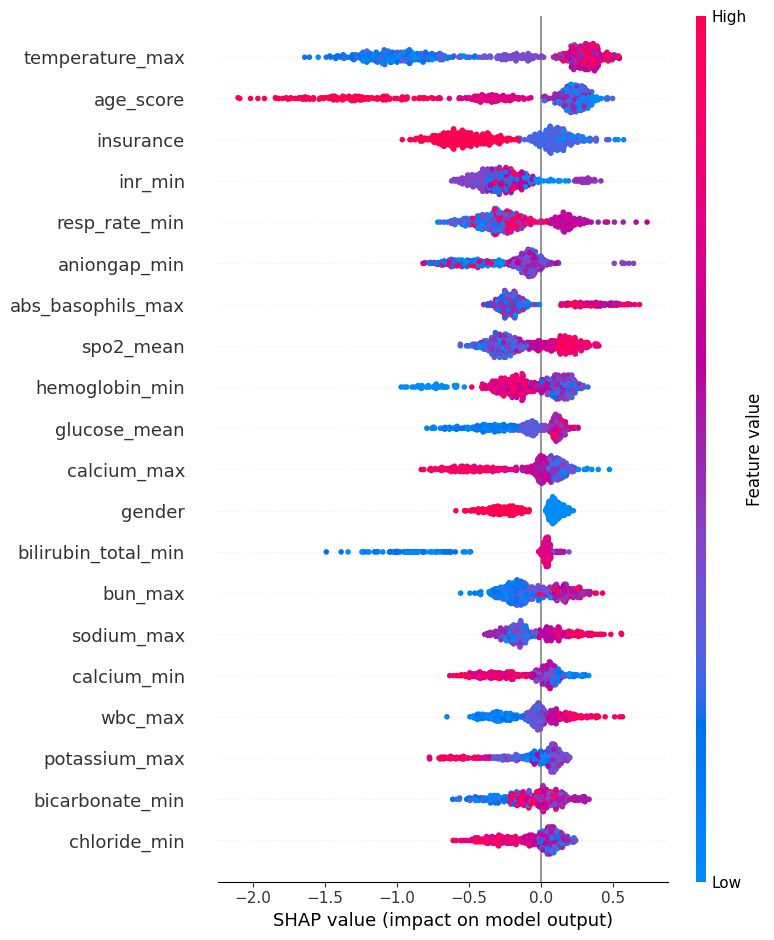

KNeighborsClassifier(n_neighbors=7)
######   Printing Shap Values for KNN   ######


PermutationExplainer explainer: 541it [00:38, 10.51it/s]                         


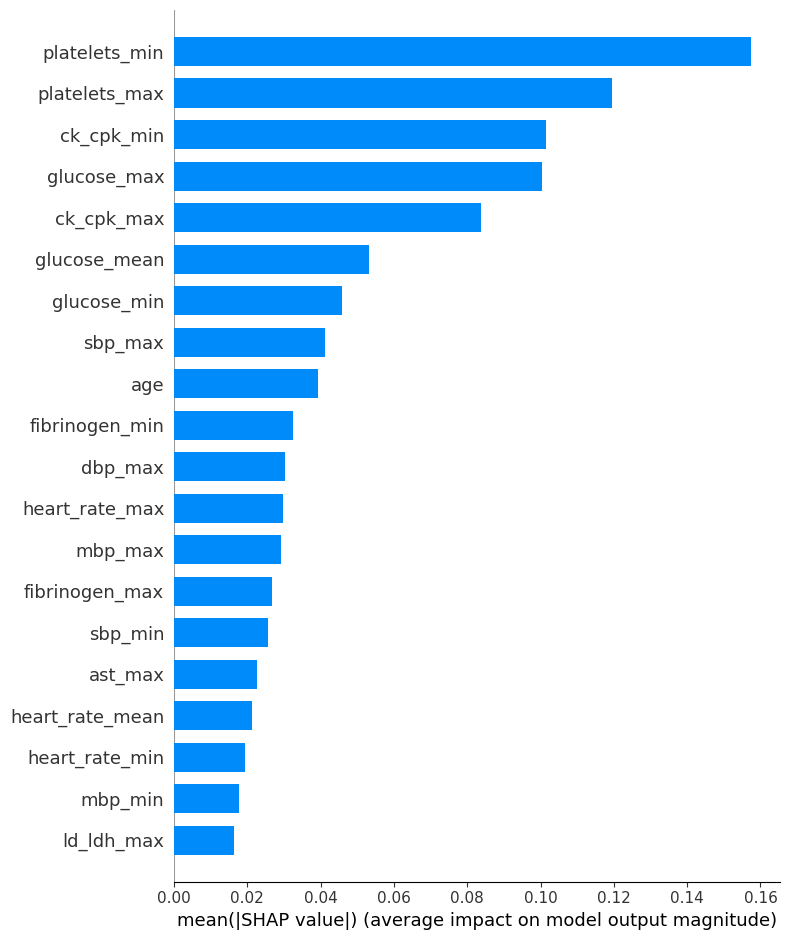

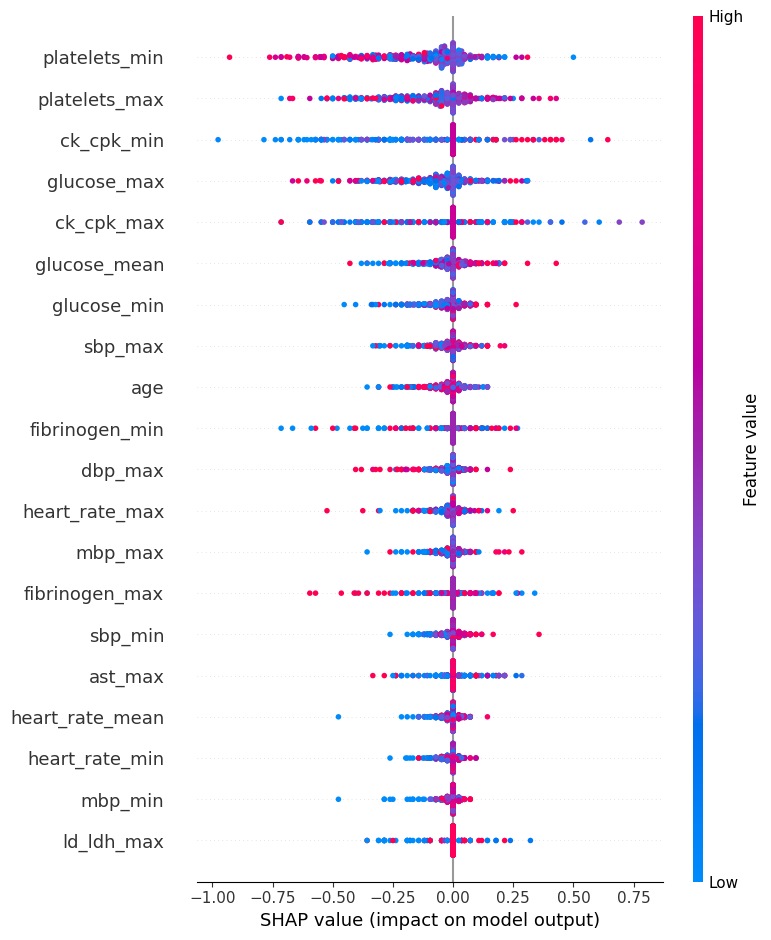

DecisionTreeClassifier(max_depth=3)
######   Printing Shap Values for DecisionTree   ######


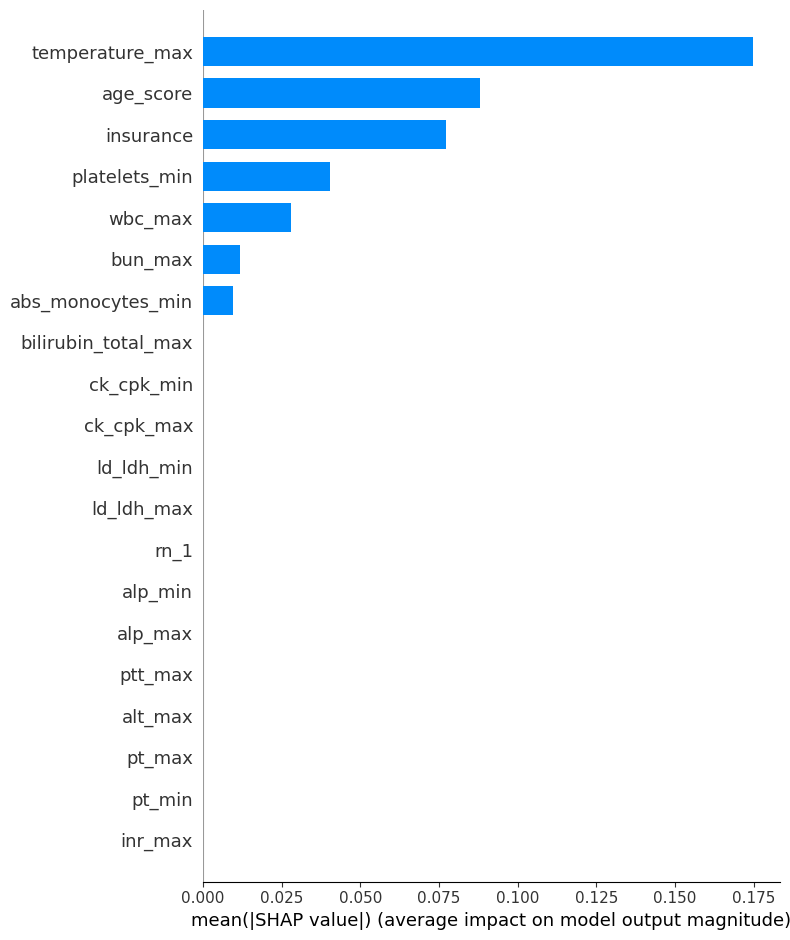

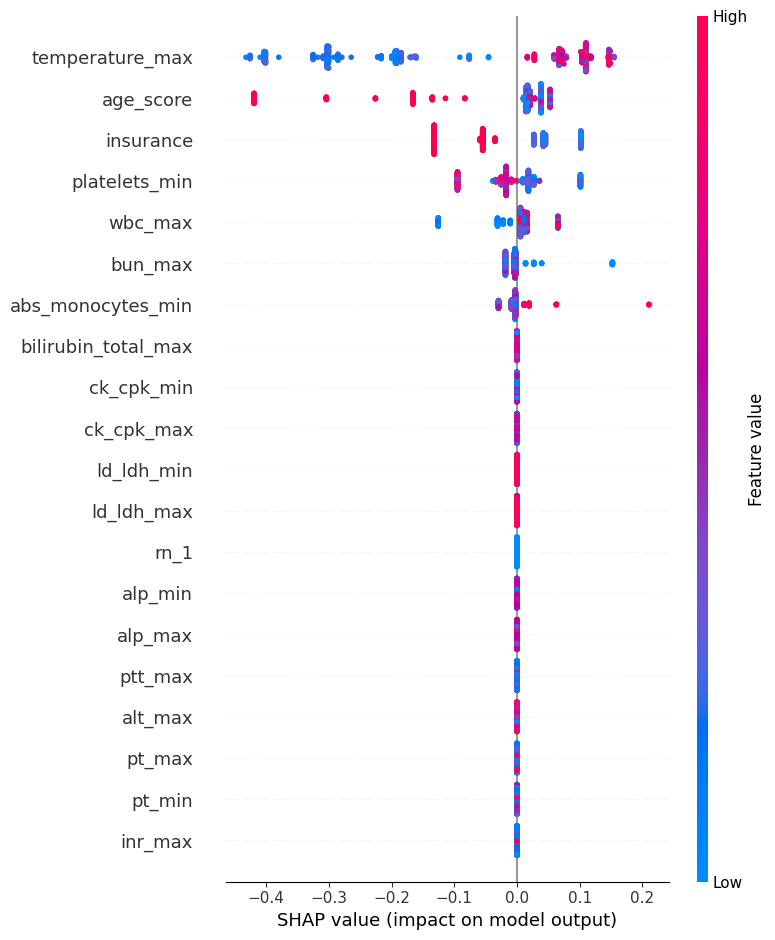

AdaBoostClassifier(n_estimators=1000)
######   Printing Shap Values for AdaBoost   ######


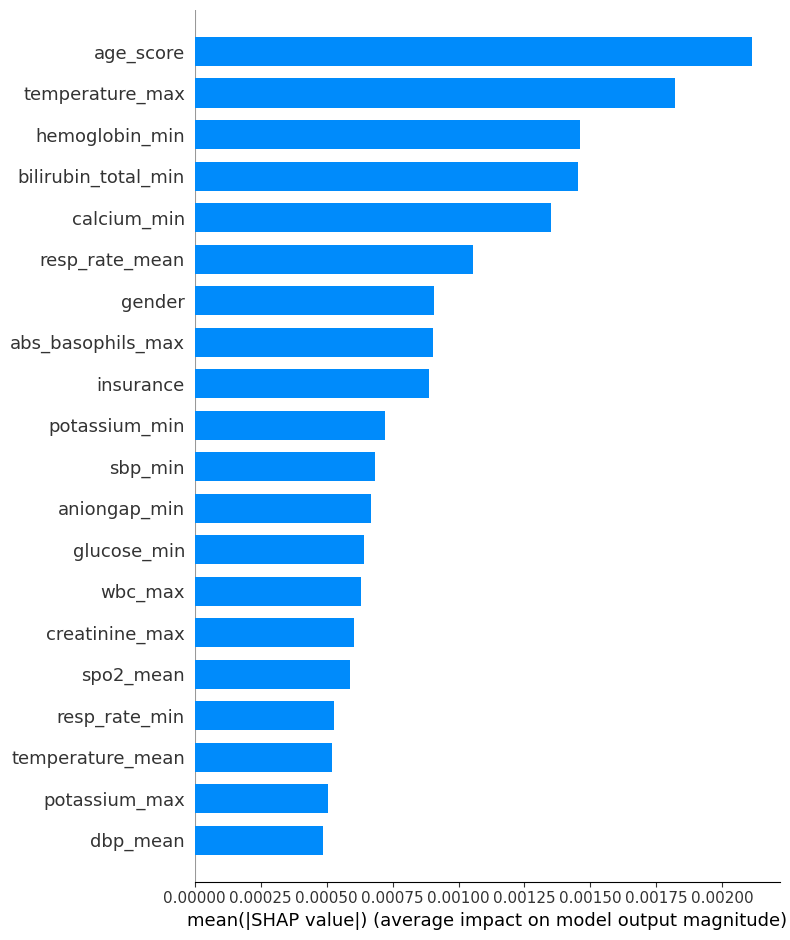

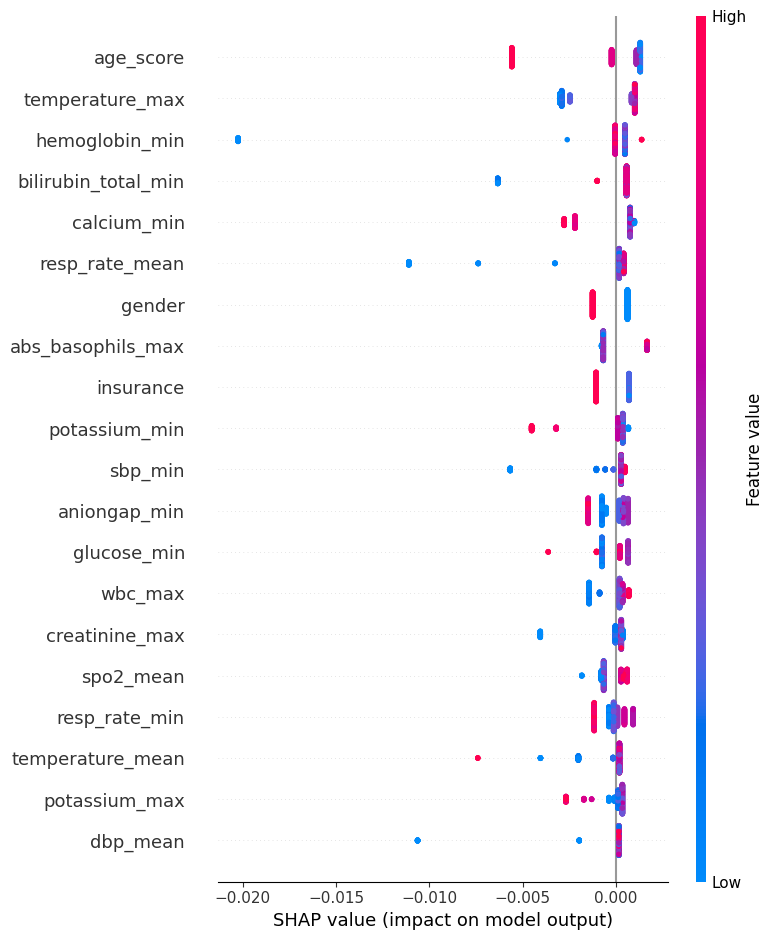

LGBMClassifier(class_weight='balanced', max_depth=6, n_estimators=2000,
               random_state=42, verbose=-1)
######   Printing Shap Values for LightGBM   ######


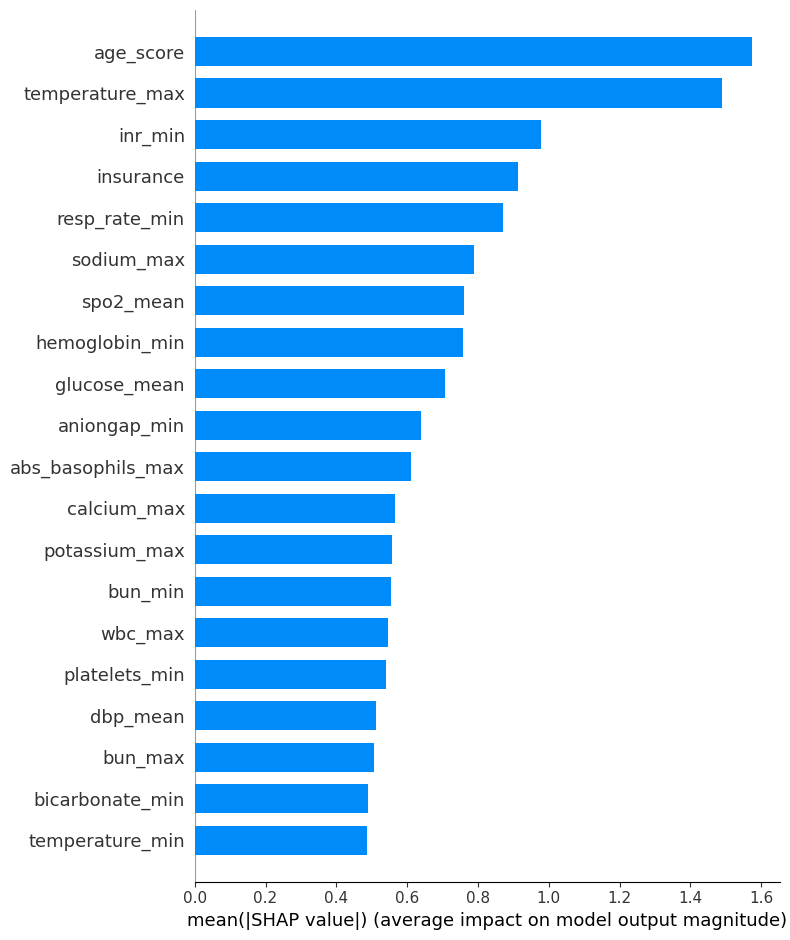

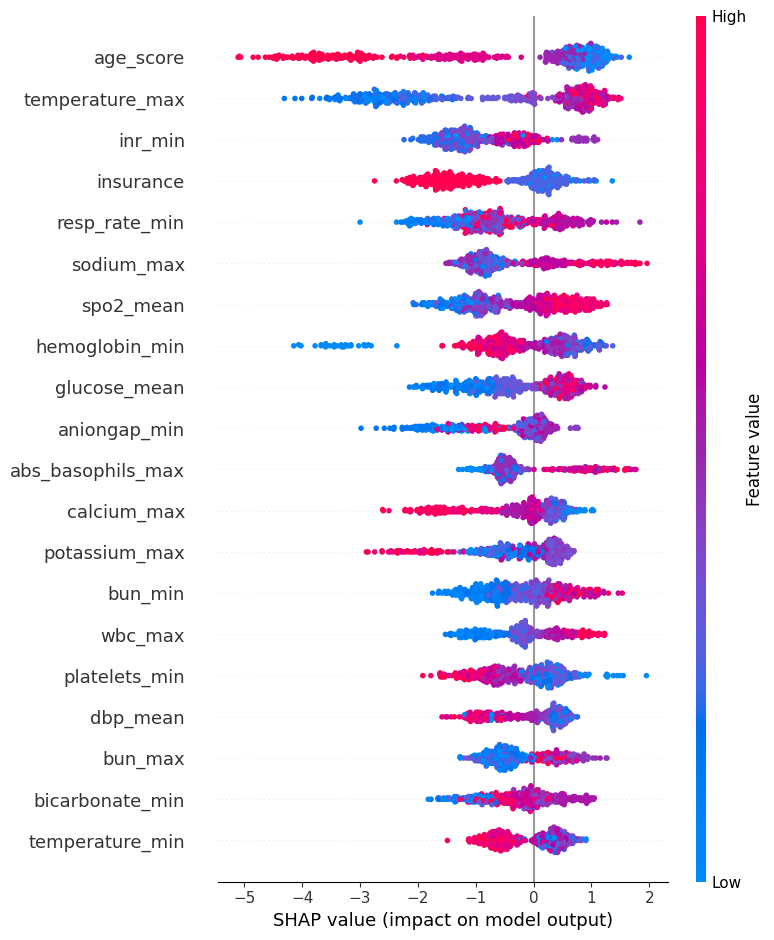


Retrain with top 10 features
RandomForest:
  - temperature_max
  - age_score
  - calcium_min
  - spo2_mean
  - gender
  - insurance
  - wbc_max
  - temperature_mean
  - glucose_mean
  - glucose_max
XGBoost:
  - temperature_max
  - age_score
  - insurance
  - inr_min
  - resp_rate_min
  - aniongap_min
  - abs_basophils_max
  - spo2_mean
  - hemoglobin_min
  - glucose_mean
KNN:
  - platelets_min
  - platelets_max
  - ck_cpk_min
  - glucose_max
  - ck_cpk_max
  - glucose_mean
  - glucose_min
  - sbp_max
  - age
  - fibrinogen_min
DecisionTree:
  - temperature_max
  - age_score
  - insurance
  - platelets_min
  - wbc_max
  - bun_max
  - abs_monocytes_min
  - bilirubin_total_max
  - ck_cpk_min
  - ck_cpk_max
AdaBoost:
  - age_score
  - temperature_max
  - hemoglobin_min
  - bilirubin_total_min
  - calcium_min
  - resp_rate_mean
  - gender
  - abs_basophils_max
  - insurance
  - potassium_min
LightGBM:
  - age_score
  - temperature_max
  - inr_min
  - insurance
  - resp_rate_min
  - sodium_

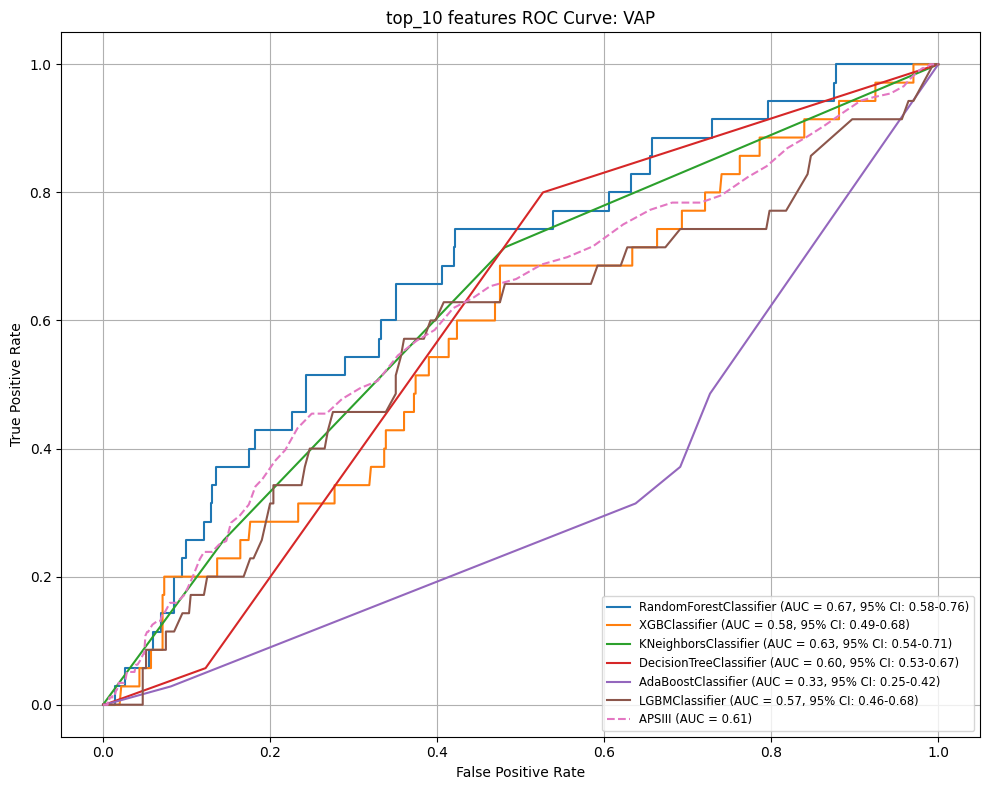


Retrain with top 20 features
RandomForest:
  - temperature_max
  - age_score
  - calcium_min
  - spo2_mean
  - gender
  - insurance
  - wbc_max
  - temperature_mean
  - glucose_mean
  - glucose_max
  - resp_rate_min
  - glucose_min
  - abs_basophils_max
  - spo2_max
  - age
  - bilirubin_total_min
  - race
  - calcium_max
  - wbc_min
  - platelets_min
XGBoost:
  - temperature_max
  - age_score
  - insurance
  - inr_min
  - resp_rate_min
  - aniongap_min
  - abs_basophils_max
  - spo2_mean
  - hemoglobin_min
  - glucose_mean
  - calcium_max
  - gender
  - bilirubin_total_min
  - bun_max
  - sodium_max
  - calcium_min
  - wbc_max
  - potassium_max
  - bicarbonate_min
  - chloride_min
KNN:
  - platelets_min
  - platelets_max
  - ck_cpk_min
  - glucose_max
  - ck_cpk_max
  - glucose_mean
  - glucose_min
  - sbp_max
  - age
  - fibrinogen_min
  - dbp_max
  - heart_rate_max
  - mbp_max
  - fibrinogen_max
  - sbp_min
  - ast_max
  - heart_rate_mean
  - heart_rate_min
  - mbp_min
  - ld_ldh_m

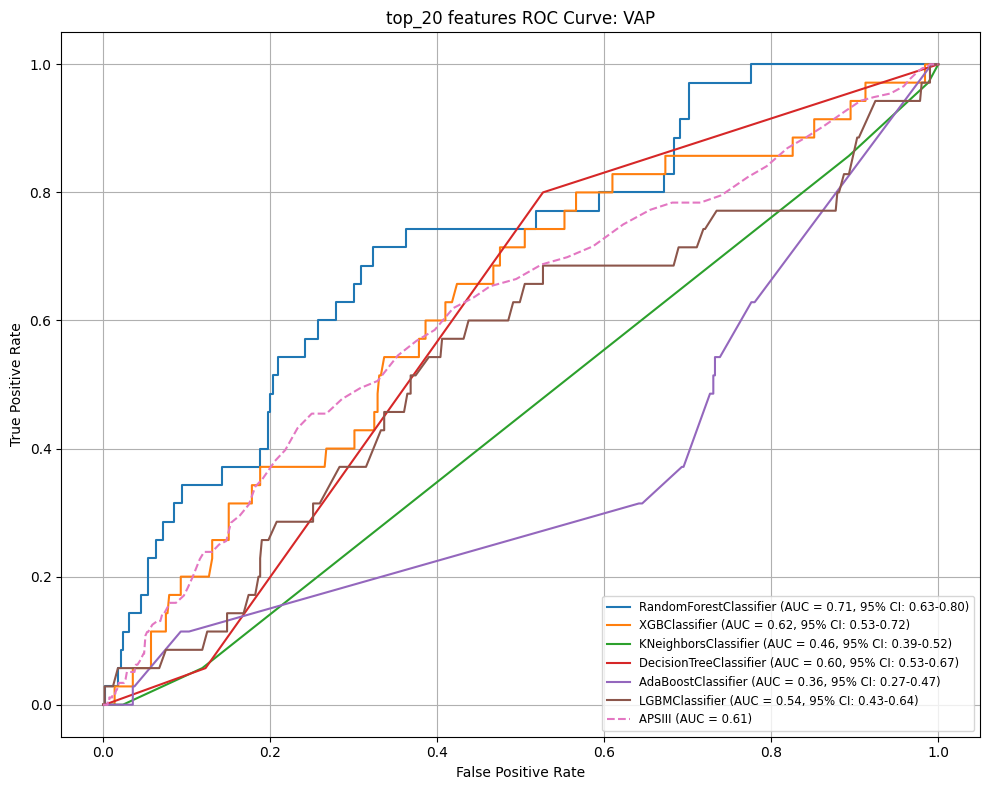


Retrain with top 30 features
RandomForest:
  - temperature_max
  - age_score
  - calcium_min
  - spo2_mean
  - gender
  - insurance
  - wbc_max
  - temperature_mean
  - glucose_mean
  - glucose_max
  - resp_rate_min
  - glucose_min
  - abs_basophils_max
  - spo2_max
  - age
  - bilirubin_total_min
  - race
  - calcium_max
  - wbc_min
  - platelets_min
  - sodium_max
  - hemoglobin_min
  - potassium_min
  - bilirubin_total_max
  - bun_min
  - heart_rate_max
  - mbp_max
  - paraplegia
  - abs_neutrophils_max
  - hematocrit_max
XGBoost:
  - temperature_max
  - age_score
  - insurance
  - inr_min
  - resp_rate_min
  - aniongap_min
  - abs_basophils_max
  - spo2_mean
  - hemoglobin_min
  - glucose_mean
  - calcium_max
  - gender
  - bilirubin_total_min
  - bun_max
  - sodium_max
  - calcium_min
  - wbc_max
  - potassium_max
  - bicarbonate_min
  - chloride_min
  - bun_min
  - glucose_min
  - heart_rate_max
  - dbp_mean
  - platelets_min
  - abs_neutrophils_min
  - temperature_min
  - potas

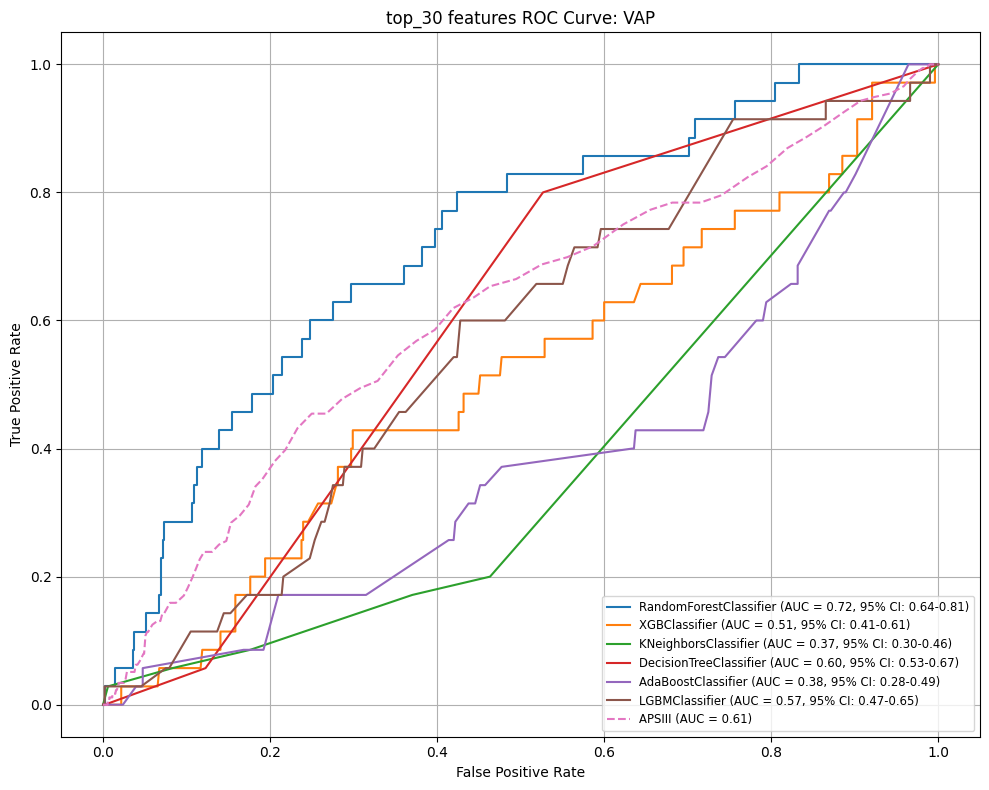


Retrain with top 40 features
RandomForest:
  - temperature_max
  - age_score
  - calcium_min
  - spo2_mean
  - gender
  - insurance
  - wbc_max
  - temperature_mean
  - glucose_mean
  - glucose_max
  - resp_rate_min
  - glucose_min
  - abs_basophils_max
  - spo2_max
  - age
  - bilirubin_total_min
  - race
  - calcium_max
  - wbc_min
  - platelets_min
  - sodium_max
  - hemoglobin_min
  - potassium_min
  - bilirubin_total_max
  - bun_min
  - heart_rate_max
  - mbp_max
  - paraplegia
  - abs_neutrophils_max
  - hematocrit_max
  - aniongap_min
  - sbp_max
  - abs_monocytes_max
  - bun_max
  - hematocrit_min
  - heart_rate_mean
  - abs_eosinophils_max
  - inr_min
  - chloride_max
  - dbp_mean
XGBoost:
  - temperature_max
  - age_score
  - insurance
  - inr_min
  - resp_rate_min
  - aniongap_min
  - abs_basophils_max
  - spo2_mean
  - hemoglobin_min
  - glucose_mean
  - calcium_max
  - gender
  - bilirubin_total_min
  - bun_max
  - sodium_max
  - calcium_min
  - wbc_max
  - potassium_max


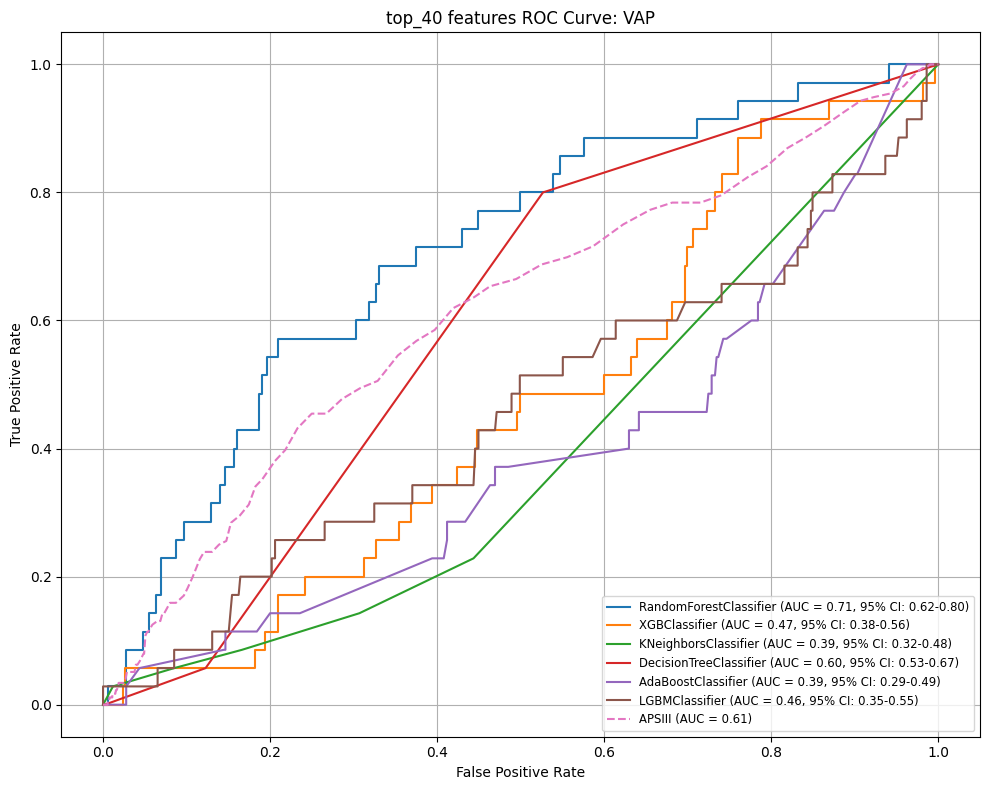


Retrain with top 50 features
RandomForest:
  - temperature_max
  - age_score
  - calcium_min
  - spo2_mean
  - gender
  - insurance
  - wbc_max
  - temperature_mean
  - glucose_mean
  - glucose_max
  - resp_rate_min
  - glucose_min
  - abs_basophils_max
  - spo2_max
  - age
  - bilirubin_total_min
  - race
  - calcium_max
  - wbc_min
  - platelets_min
  - sodium_max
  - hemoglobin_min
  - potassium_min
  - bilirubin_total_max
  - bun_min
  - heart_rate_max
  - mbp_max
  - paraplegia
  - abs_neutrophils_max
  - hematocrit_max
  - aniongap_min
  - sbp_max
  - abs_monocytes_max
  - bun_max
  - hematocrit_min
  - heart_rate_mean
  - abs_eosinophils_max
  - inr_min
  - chloride_max
  - dbp_mean
  - spo2_min
  - resp_rate_mean
  - abs_eosinophils_min
  - hemoglobin_max
  - creatinine_max
  - heart_rate_min
  - abs_lymphocytes_min
  - platelets_max
  - chloride_min
  - ptt_max
XGBoost:
  - temperature_max
  - age_score
  - insurance
  - inr_min
  - resp_rate_min
  - aniongap_min
  - abs_baso

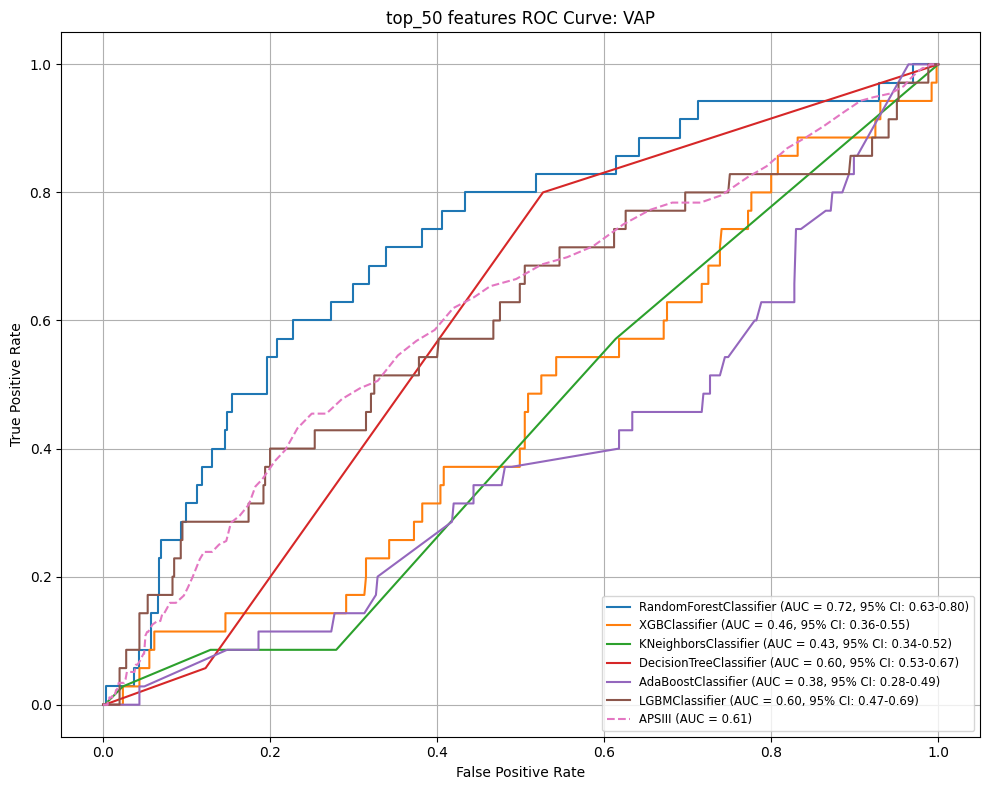

In [33]:
shap_dict = {}
for i, model in bms_clone.items():
  print(model)
  print(f"######   Printing Shap Values for {i}   ######")
  if i == 'RandomForest':
    shap_values = shap_for_rt(model, x_test)
  elif i == 'XGBoost' or i == 'LightGBM':
    shap_values = shap_for_xgb(model,  x_test)
  elif i == 'KNN':
    shap_values = shap_for_non_tree(model, x_train, x_test)
  elif i == 'DecisionTree':
    shap_values = shap_for_rt(model, x_test)
  elif i == 'AdaBoost':
    model.base_estimator_ = model.estimator_
    # adaboost應該用跟random tree一樣的tree explainer，但需要改一下原本套件的寫法，不改的話就用跟knn一樣的方法
    shap_values = shap_for_ada(model, x_test)
  elif i == 'SVM':
    shap_values = shap_for_svm(model, x_test)

  if hasattr(shap_values, 'values'):
    values = shap_values.values
  else:
    values = shap_values

  if values.ndim == 3:
    shap_importance = np.abs(values[:, :, 1]).mean(axis=0)
  else:
    shap_importance = np.abs(values).mean(axis=0)
  top_indices_all = np.argsort(shap_importance)[::-1]
  shap_dict[i] = top_indices_all

# Top [10 20 30 40 50] features

In [ ]:
for top_k in [10, 20, 30, 40, 50]:
    print(f"\nRetrain with top {top_k} features")
    top_features = {name : x_test.columns[top_indices_all[:top_k]] for name, top_indices_all in shap_dict.items()}
    # 印出每個模型的 top-k 特徵名稱
    for name, features in top_features.items():
        print(f"{name}:")
        for f in features:
            print(f"  - {f}")

    # top_features = {name : x_test.columns[top_indices_all[:top_k]] for name, top_indices_all in shap_dict.items()}
    top_models = {name : clone(model) for name, model in best_models.items()}
    [model.fit(x_train[top_features[name]], y_train) for name, model in top_models.items()]
    top_x_tests = {name : x_test[top_features[name]] for name, model in top_models.items()}
    #print(top_x_tests)
    infos = [[], []]
    for name in top_models.keys():
        infos[0].append(top_models[name])
        infos[1].append(top_x_tests[name].values)
    plot_roc_curve(infos[0], infos[1], y_test, classes, f'top_{top_k} features')

    #monitor_results(model_top, x_train_top, x_test_top, y_train, y_test)